In [1]:
from characteristic_function_functions import *
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
import math
import cmath
from scipy.integrate import simpson, romb
from scipy.stats import iqr, norm, gaussian_kde
from scipy.special import erfc, wofz
import pickle
import os
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
import warnings

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
mu_list = np.linspace(0, 8, 51)


nu = 1.2
alpha = 1 + 0.5 * 1j
kappa = 0.85
n_precision = 1000


trial_times = 5
n = 500


phi1_true_list = []
phi1_avg_gaussian_list = []
phi1_std_real_gaussian_list = []
phi1_std_imag_gaussian_list = []

diff_phi_t1_Gaussian_list = []
bd_phi_t1_Gaussian_list = []

for mu in tqdm(mu_list):

    phi1_true = compute_perfect_phi(mu, nu, alpha, 1)
    phi1_true_list.append(phi1_true)

    phi1_gaussian_list_per_mu = []
    L_limit = find_suitable_L(mu, nu, alpha)
    X_precision = np.linspace(-L_limit, L_limit, n_precision)
    pdf = normalized_cat_state_pdf(mu, nu, alpha, X_precision)

    for _ in range(trial_times):

        X_samples = samplings_with_noisy_pdf(pdf, X_precision, n, kappa)
        W_Gaussian = reconstruct_pdf_mle(X_samples, X_precision)
        phi_t1_vals_gaussian, optimal_bd = compute_gaussian_phi_at_t_optimal(mu, nu, X_precision, X_samples, W_Gaussian, t=1)

        phi1_gaussian_list_per_mu.append(phi_t1_vals_gaussian)
        if np.abs(mu - 0.8) < 1e-4:
            diff_phi_t1_Gaussian_list.append(np.abs(phi1_true - phi_t1_vals_gaussian)**2)
            bd_phi_t1_Gaussian_list.append(optimal_bd)

    phi1_avg_gaussian = np.mean(phi1_gaussian_list_per_mu, axis = 0)
    phi1_std_real_gaussian = np.std(np.array(phi1_gaussian_list_per_mu).real, axis = 0)
    phi1_std_imag_gaussian = np.std(np.array(phi1_gaussian_list_per_mu).imag, axis = 0)

    phi1_avg_gaussian_list.append(phi1_avg_gaussian)
    phi1_std_real_gaussian_list.append(phi1_std_real_gaussian)
    phi1_std_imag_gaussian_list.append(phi1_std_imag_gaussian)


avg_error = np.mean(diff_phi_t1_Gaussian_list)
std_error = np.std(diff_phi_t1_Gaussian_list)
avg_bd = np.mean(bd_phi_t1_Gaussian_list)
std_bd = np.std(bd_phi_t1_Gaussian_list)

phi1_true_list = np.array(phi1_true_list)
phi1_avg_gaussian_list = np.array(phi1_avg_gaussian_list)
phi1_std_real_gaussian_list = np.array(phi1_std_real_gaussian_list)   
phi1_std_imag_gaussian_list = np.array(phi1_std_imag_gaussian_list)    

100%|██████████| 51/51 [00:07<00:00,  7.20it/s]


Average MSE of Gaussian kernel for phi(1):  0.006755350992961495  +/-  0.0029400537737245586
Average bandwidth of Gaussian kernel for phi(1):  0.06503410652069434  +/-  0.003136318441420057


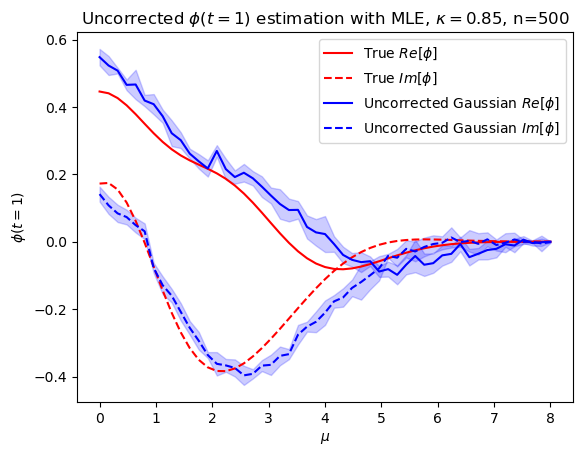

In [4]:
plt.plot(mu_list, phi1_true_list.real, color = 'red', label = 'True $Re[\phi]$')
plt.plot(mu_list, phi1_true_list.imag, color = 'red', linestyle = '--', label = 'True $Im[\phi]$')

plt.plot(mu_list, phi1_avg_gaussian_list.real, color = 'blue', label = 'Uncorrected Gaussian $Re[\phi]$')
plt.plot(mu_list, phi1_avg_gaussian_list.imag, color = 'blue', linestyle = '--', label = 'Uncorrected Gaussian $Im[\phi]$')
plt.fill_between(mu_list, phi1_avg_gaussian_list.real - phi1_std_real_gaussian_list, phi1_avg_gaussian_list.real + phi1_std_real_gaussian_list, color = 'blue', alpha = 0.2)
plt.fill_between(mu_list, phi1_avg_gaussian_list.imag - phi1_std_imag_gaussian_list, phi1_avg_gaussian_list.imag + phi1_std_imag_gaussian_list, color = 'blue', alpha = 0.2)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\phi(t=1)$')
plt.title(r'Uncorrected $\phi(t=1)$ estimation with MLE, $\kappa=$' + str(kappa) + ', n=' + str(n))
plt.legend()


print("Average MSE of Gaussian kernel for phi(1): ", avg_error, " +/- ", std_error)
print("Average bandwidth of Gaussian kernel for phi(1): ", avg_bd, " +/- ", std_bd)